In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
from sklearn.model_selection import KFold
import torch.optim as optim
from torchvision import transforms, datasets

In [ ]:
batch_size = 64
num_epochs = 10
learning_rate = 0.0001
k=5

In [ ]:
# Load data
root = './MNIST_Fashion'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
dataset = datasets.FashionMNIST(root=root, transform=transform, download=True)
kfold = KFold(n_splits=k, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 18378816.59it/s]


Extracting ./MNIST_Fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_Fashion/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 340980.13it/s]


Extracting ./MNIST_Fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_Fashion/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6144736.09it/s]


Extracting ./MNIST_Fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_Fashion/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14066629.96it/s]

Extracting ./MNIST_Fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_Fashion/FashionMNIST/raw



DNN model

In [ ]:
#device = torch.device(device + ":0")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.layer1 = nn.Sequential(
            torch.nn.Linear(784, 256, bias=True),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            torch.nn.Linear(256, 64, bias=True),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            torch.nn.Linear(64,32,bias=True),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            torch.nn.Linear(32, 10, bias=True)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        x_out = self.layer3(x_out)
        x_out = self.layer4(x_out)
        return x_out

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight) 

model = DNN().to(device)
model.apply(weights_init)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_accuracy = 0
costs = []
num_epochs = 10

for fold, (train_idxs, val_idxs) in enumerate(kfold.split(dataset)):
    # Split data into training and validation sets
    train_data = torch.utils.data.Subset(dataset, train_idxs)
    val_data = torch.utils.data.Subset(dataset, val_idxs)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    total_batch = len(train_loader)
    
    # Initialize model and optimizer
    model = DNN().to(device)
    model.apply(weights_init)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    for epoch in range(num_epochs):
        total_cost = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_cost += loss

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        avg_cost = total_cost / total_batch
        print('Fold [{}/{}], Epoch [{}/{}], Validation Accuracy: {:.2f}%, Cost: {:.9f})'
              .format(fold+1, k, epoch+1, num_epochs, accuracy, avg_cost))
        total_accuracy += accuracy
        costs.append(avg_cost) 

# Calculate average accuracy across all folds
avg_accuracy = total_accuracy / k
print('Average Validation Accuracy: {:.2f}%'.format(avg_accuracy))

Fold [1/5], Epoch [1/10], Validation Accuracy: 84.26%, Cost: 0.905805886)
Fold [1/5], Epoch [2/10], Validation Accuracy: 86.62%, Cost: 0.523573637)
Fold [1/5], Epoch [3/10], Validation Accuracy: 87.40%, Cost: 0.421868324)
Fold [1/5], Epoch [4/10], Validation Accuracy: 87.53%, Cost: 0.368444920)
Fold [1/5], Epoch [5/10], Validation Accuracy: 88.07%, Cost: 0.334112495)
Fold [1/5], Epoch [6/10], Validation Accuracy: 88.61%, Cost: 0.306347072)
Fold [1/5], Epoch [7/10], Validation Accuracy: 88.55%, Cost: 0.284090400)
Fold [1/5], Epoch [8/10], Validation Accuracy: 88.80%, Cost: 0.267960578)
Fold [1/5], Epoch [9/10], Validation Accuracy: 88.97%, Cost: 0.250610113)
Fold [1/5], Epoch [10/10], Validation Accuracy: 88.88%, Cost: 0.237865880)
Fold [2/5], Epoch [1/10], Validation Accuracy: 84.18%, Cost: 0.900018990)
Fold [2/5], Epoch [2/10], Validation Accuracy: 86.58%, Cost: 0.519736350)
Fold [2/5], Epoch [3/10], Validation Accuracy: 87.37%, Cost: 0.424961030)
Fold [2/5], Epoch [4/10], Validation 

In [ ]:
# Load test data
test_data = datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Test model
model.eval()
test_accuracy = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_accuracy += (output.argmax(1) == target).sum().item()

test_accuracy /= len(test_data)
print('Test accuracy: {:.4f}'.format(test_accuracy))

Test accuracy: 0.8771


Change learning rate

In [ ]:
learning_rate = 0.1
total_accuracy = 0
costs = []

for fold, (train_idxs, val_idxs) in enumerate(kfold.split(dataset)):
    # Split data into training and validation sets
    train_data = torch.utils.data.Subset(dataset, train_idxs)
    val_data = torch.utils.data.Subset(dataset, val_idxs)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    total_batch = len(train_loader)
    
    # Initialize model and optimizer
    model = DNN().to(device)
    model.apply(weights_init)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    for epoch in range(num_epochs):
        total_cost = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_cost += loss

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        avg_cost = total_cost / total_batch
        print('Fold [{}/{}], Epoch [{}/{}], Validation Accuracy: {:.2f}%, Cost: {:.9f})'
              .format(fold+1, k, epoch+1, num_epochs, accuracy, avg_cost))
        total_accuracy += accuracy
        costs.append(avg_cost) 

# Calculate average accuracy across all folds
avg_accuracy = total_accuracy / k
print('Average Validation Accuracy: {:.2f}%'.format(avg_accuracy))

# Load test data
test_data = datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Test model
model.eval()
test_accuracy = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_accuracy += (output.argmax(1) == target).sum().item()

test_accuracy /= len(test_data)
print('Test accuracy: {:.4f}'.format(test_accuracy))

Fold [1/5], Epoch [1/10], Validation Accuracy: 82.56%, Cost: 0.597594857)
Fold [1/5], Epoch [2/10], Validation Accuracy: 85.50%, Cost: 0.466238886)
Fold [1/5], Epoch [3/10], Validation Accuracy: 83.97%, Cost: 0.433166146)
Fold [1/5], Epoch [4/10], Validation Accuracy: 86.72%, Cost: 0.400793284)
Fold [1/5], Epoch [5/10], Validation Accuracy: 86.33%, Cost: 0.387136161)
Fold [1/5], Epoch [6/10], Validation Accuracy: 86.63%, Cost: 0.380127162)
Fold [1/5], Epoch [7/10], Validation Accuracy: 84.83%, Cost: 0.364344209)
Fold [1/5], Epoch [8/10], Validation Accuracy: 86.30%, Cost: 0.352390379)
Fold [1/5], Epoch [9/10], Validation Accuracy: 86.87%, Cost: 0.339462459)
Fold [1/5], Epoch [10/10], Validation Accuracy: 86.58%, Cost: 0.332229197)
Fold [2/5], Epoch [1/10], Validation Accuracy: 82.94%, Cost: 0.595361769)
Fold [2/5], Epoch [2/10], Validation Accuracy: 85.97%, Cost: 0.468436033)
Fold [2/5], Epoch [3/10], Validation Accuracy: 85.78%, Cost: 0.443649292)
Fold [2/5], Epoch [4/10], Validation 

In [ ]:
learning_rate = 0.001
total_accuracy = 0
costs = []

for fold, (train_idxs, val_idxs) in enumerate(kfold.split(dataset)):
    # Split data into training and validation sets
    train_data = torch.utils.data.Subset(dataset, train_idxs)
    val_data = torch.utils.data.Subset(dataset, val_idxs)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    total_batch = len(train_loader)
    
    # Initialize model and optimizer
    model = DNN().to(device)
    model.apply(weights_init)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    for epoch in range(num_epochs):
        total_cost = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_cost += loss

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        avg_cost = total_cost / total_batch
        print('Fold [{}/{}], Epoch [{}/{}], Validation Accuracy: {:.2f}%, Cost: {:.9f})'
              .format(fold+1, k, epoch+1, num_epochs, accuracy, avg_cost))
        total_accuracy += accuracy
        costs.append(avg_cost) 

# Calculate average accuracy across all folds
avg_accuracy = total_accuracy / k
print('Average Validation Accuracy: {:.2f}%'.format(avg_accuracy))

# Load test data
test_data = datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Test model
model.eval()
test_accuracy = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_accuracy += (output.argmax(1) == target).sum().item()

test_accuracy /= len(test_data)
print('Test accuracy: {:.4f}'.format(test_accuracy))

Fold [1/5], Epoch [1/10], Validation Accuracy: 87.03%, Cost: 0.520763516)
Fold [1/5], Epoch [2/10], Validation Accuracy: 86.74%, Cost: 0.359769017)
Fold [1/5], Epoch [3/10], Validation Accuracy: 87.54%, Cost: 0.318567038)
Fold [1/5], Epoch [4/10], Validation Accuracy: 88.40%, Cost: 0.289241701)
Fold [1/5], Epoch [5/10], Validation Accuracy: 86.59%, Cost: 0.272334009)
Fold [1/5], Epoch [6/10], Validation Accuracy: 88.67%, Cost: 0.251106411)
Fold [1/5], Epoch [7/10], Validation Accuracy: 88.73%, Cost: 0.236190811)
Fold [1/5], Epoch [8/10], Validation Accuracy: 87.78%, Cost: 0.224025577)
Fold [1/5], Epoch [9/10], Validation Accuracy: 88.81%, Cost: 0.212642372)
Fold [1/5], Epoch [10/10], Validation Accuracy: 89.45%, Cost: 0.200667396)
Fold [2/5], Epoch [1/10], Validation Accuracy: 86.55%, Cost: 0.513029635)
Fold [2/5], Epoch [2/10], Validation Accuracy: 86.14%, Cost: 0.357000947)
Fold [2/5], Epoch [3/10], Validation Accuracy: 87.84%, Cost: 0.314732611)
Fold [2/5], Epoch [4/10], Validation 

Dropout

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DNN_DP(nn.Module):
    def __init__(self):
        super(DNN_DP, self).__init__()
        self.layer1 = nn.Sequential(
            torch.nn.Linear(784, 256, bias=True),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            torch.nn.Linear(256, 64, bias=True),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            torch.nn.Linear(64, 32, bias=True),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            torch.nn.Linear(32, 10, bias=True)
        )
        #Drop out
        self.layer1_dropout = nn.Dropout(0.3) 
        self.layer2_dropout = nn.Dropout(0.3)
        self.layer3_dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer1_dropout(x_out) #Apply dropout
        x_out = self.layer2(x_out)
        x_out = self.layer2_dropout(x_out) #Apply dropout
        x_out = self.layer3(x_out)
        x_out = self.layer3_dropout(x_out) #Apply dropout
        x_out = self.layer4(x_out)
        return x_out

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight) 

model = DNN_DP().to(device)
model.apply(weights_init)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import keras
learning_rate = 0.001
total_accuracy = 0
costs = []

for fold, (train_idxs, val_idxs) in enumerate(kfold.split(dataset)):
    # Split data into training and validation sets
    train_data = torch.utils.data.Subset(dataset, train_idxs)
    val_data = torch.utils.data.Subset(dataset, val_idxs)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    total_batch = len(train_loader)

    # Initialize model and optimizer
    model = DNN_DP().to(device)
    model.apply(weights_init)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    for epoch in range(num_epochs):
        total_cost = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_cost += loss

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        avg_cost = total_cost / total_batch
        print('Fold [{}/{}], Epoch [{}/{}], Validation Accuracy: {:.2f}%, Cost: {:.9f})'
              .format(fold+1, k, epoch+1, num_epochs, accuracy, avg_cost))
        total_accuracy += accuracy
        costs.append(avg_cost) 

# Calculate average accuracy across all folds
avg_accuracy = total_accuracy / k
print('Average Validation Accuracy: {:.2f}%'.format(avg_accuracy))

# Load test data
test_data = datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Test model
model.eval()
test_accuracy = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_accuracy += (output.argmax(1) == target).sum().item()

test_accuracy /= len(test_data)
print('Test accuracy: {:.4f}'.format(test_accuracy))

Fold [1/5], Epoch [1/10], Validation Accuracy: 84.66%, Cost: 0.829307795)
Fold [1/5], Epoch [2/10], Validation Accuracy: 85.95%, Cost: 0.549224079)
Fold [1/5], Epoch [3/10], Validation Accuracy: 86.83%, Cost: 0.497069746)
Fold [1/5], Epoch [4/10], Validation Accuracy: 87.00%, Cost: 0.455953300)
Fold [1/5], Epoch [5/10], Validation Accuracy: 87.35%, Cost: 0.434543133)
Fold [1/5], Epoch [6/10], Validation Accuracy: 88.09%, Cost: 0.416979522)
Fold [1/5], Epoch [7/10], Validation Accuracy: 87.51%, Cost: 0.405581295)
Fold [1/5], Epoch [8/10], Validation Accuracy: 88.42%, Cost: 0.390873492)
Fold [1/5], Epoch [9/10], Validation Accuracy: 88.40%, Cost: 0.384859294)
Fold [1/5], Epoch [10/10], Validation Accuracy: 88.43%, Cost: 0.371076018)
Fold [2/5], Epoch [1/10], Validation Accuracy: 84.56%, Cost: 0.826327860)
Fold [2/5], Epoch [2/10], Validation Accuracy: 85.46%, Cost: 0.557180643)
Fold [2/5], Epoch [3/10], Validation Accuracy: 86.82%, Cost: 0.500364542)
Fold [2/5], Epoch [4/10], Validation 

In [ ]:
print(costs)

[tensor(0.8293, grad_fn=<DivBackward0>), tensor(0.5492, grad_fn=<DivBackward0>), tensor(0.4971, grad_fn=<DivBackward0>), tensor(0.4560, grad_fn=<DivBackward0>), tensor(0.4345, grad_fn=<DivBackward0>), tensor(0.4170, grad_fn=<DivBackward0>), tensor(0.4056, grad_fn=<DivBackward0>), tensor(0.3909, grad_fn=<DivBackward0>), tensor(0.3849, grad_fn=<DivBackward0>), tensor(0.3711, grad_fn=<DivBackward0>), tensor(0.8263, grad_fn=<DivBackward0>), tensor(0.5572, grad_fn=<DivBackward0>), tensor(0.5004, grad_fn=<DivBackward0>), tensor(0.4590, grad_fn=<DivBackward0>), tensor(0.4404, grad_fn=<DivBackward0>), tensor(0.4222, grad_fn=<DivBackward0>), tensor(0.4067, grad_fn=<DivBackward0>), tensor(0.3955, grad_fn=<DivBackward0>), tensor(0.3841, grad_fn=<DivBackward0>), tensor(0.3790, grad_fn=<DivBackward0>), tensor(0.8201, grad_fn=<DivBackward0>), tensor(0.5473, grad_fn=<DivBackward0>), tensor(0.4886, grad_fn=<DivBackward0>), tensor(0.4546, grad_fn=<DivBackward0>), tensor(0.4326, grad_fn=<DivBackward0>),

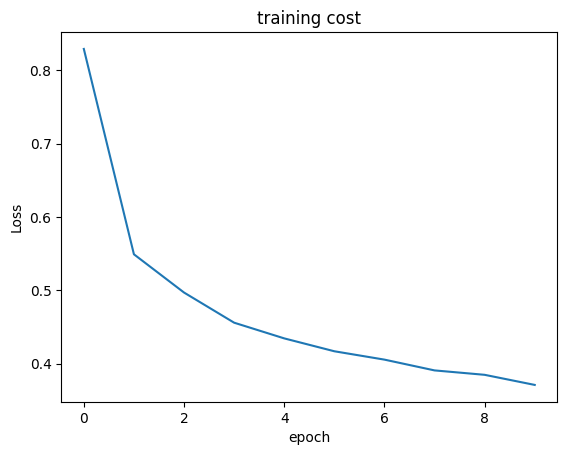

In [ ]:
#costs graph
import matplotlib.pyplot as plt

cost_values = [cost.detach().item() for cost in costs[:10]]
plt.plot(cost_values)
plt.title('training cost')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

Change optimizer

In [ ]:
#SGD optimizer
learning_rate = 0.001
total_accuracy = 0
costs = []

for fold, (train_idxs, val_idxs) in enumerate(kfold.split(dataset)):
    # Split data into training and validation sets
    train_data = torch.utils.data.Subset(dataset, train_idxs)
    val_data = torch.utils.data.Subset(dataset, val_idxs)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    total_batch = len(train_loader)
    
    # Initialize model and optimizer
    model = DNN().to(device)
    model.apply(weights_init)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Train model
    for epoch in range(num_epochs):
        total_cost = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_cost += loss

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        avg_cost = total_cost / total_batch
        print('Fold [{}/{}], Epoch [{}/{}], Validation Accuracy: {:.2f}%, Cost: {:.9f})'
              .format(fold+1, k, epoch+1, num_epochs, accuracy, avg_cost))
        total_accuracy += accuracy
        costs.append(avg_cost) 

# Calculate average accuracy across all folds
avg_accuracy = total_accuracy / k
print('Average Validation Accuracy: {:.2f}%'.format(avg_accuracy))

# Load test data
test_data = datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Test model
model.eval()
test_accuracy = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_accuracy += (output.argmax(1) == target).sum().item()

test_accuracy /= len(test_data)
print('Test accuracy: {:.4f}'.format(test_accuracy))

Fold [1/5], Epoch [1/10], Validation Accuracy: 69.25%, Cost: 1.511438131)
Fold [1/5], Epoch [2/10], Validation Accuracy: 74.77%, Cost: 1.074078560)
Fold [1/5], Epoch [3/10], Validation Accuracy: 76.53%, Cost: 0.916067302)
Fold [1/5], Epoch [4/10], Validation Accuracy: 77.77%, Cost: 0.821738958)
Fold [1/5], Epoch [5/10], Validation Accuracy: 79.12%, Cost: 0.751093686)
Fold [1/5], Epoch [6/10], Validation Accuracy: 79.79%, Cost: 0.698865891)
Fold [1/5], Epoch [7/10], Validation Accuracy: 80.66%, Cost: 0.658154726)
Fold [1/5], Epoch [8/10], Validation Accuracy: 81.62%, Cost: 0.627459168)
Fold [1/5], Epoch [9/10], Validation Accuracy: 81.88%, Cost: 0.596993029)
Fold [1/5], Epoch [10/10], Validation Accuracy: 82.47%, Cost: 0.570570469)
Fold [2/5], Epoch [1/10], Validation Accuracy: 68.82%, Cost: 1.566738486)
Fold [2/5], Epoch [2/10], Validation Accuracy: 74.50%, Cost: 1.087374210)
Fold [2/5], Epoch [3/10], Validation Accuracy: 77.09%, Cost: 0.915445745)
Fold [2/5], Epoch [4/10], Validation 

In [ ]:
#RMSProp optimizer
learning_rate = 0.001
total_accuracy = 0
costs = []

for fold, (train_idxs, val_idxs) in enumerate(kfold.split(dataset)):
    # Split data into training and validation sets
    train_data = torch.utils.data.Subset(dataset, train_idxs)
    val_data = torch.utils.data.Subset(dataset, val_idxs)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    total_batch = len(train_loader)
    
    # Initialize model and optimizer
    model = DNN().to(device)
    model.apply(weights_init)

    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    # Train model
    for epoch in range(num_epochs):
        total_cost = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_cost += loss

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        avg_cost = total_cost / total_batch
        print('Fold [{}/{}], Epoch [{}/{}], Validation Accuracy: {:.2f}%, Cost: {:.9f})'
              .format(fold+1, k, epoch+1, num_epochs, accuracy, avg_cost))
        total_accuracy += accuracy
        costs.append(avg_cost) 

# Calculate average accuracy across all folds
avg_accuracy = total_accuracy / k
print('Average Validation Accuracy: {:.2f}%'.format(avg_accuracy))

# Load test data
test_data = datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Test model
model.eval()
test_accuracy = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_accuracy += (output.argmax(1) == target).sum().item()

test_accuracy /= len(test_data)
print('Test accuracy: {:.4f}'.format(test_accuracy))

Fold [1/5], Epoch [1/10], Validation Accuracy: 87.23%, Cost: 0.488964081)
Fold [1/5], Epoch [2/10], Validation Accuracy: 87.66%, Cost: 0.355699778)
Fold [1/5], Epoch [3/10], Validation Accuracy: 88.47%, Cost: 0.312944770)
Fold [1/5], Epoch [4/10], Validation Accuracy: 87.89%, Cost: 0.286788613)
Fold [1/5], Epoch [5/10], Validation Accuracy: 88.17%, Cost: 0.268008858)
Fold [1/5], Epoch [6/10], Validation Accuracy: 87.12%, Cost: 0.248534858)
Fold [1/5], Epoch [7/10], Validation Accuracy: 88.76%, Cost: 0.234506056)
Fold [1/5], Epoch [8/10], Validation Accuracy: 89.42%, Cost: 0.221487015)
Fold [1/5], Epoch [9/10], Validation Accuracy: 89.19%, Cost: 0.211728901)
Fold [1/5], Epoch [10/10], Validation Accuracy: 89.17%, Cost: 0.197176009)
Fold [2/5], Epoch [1/10], Validation Accuracy: 86.84%, Cost: 0.483947396)
Fold [2/5], Epoch [2/10], Validation Accuracy: 88.01%, Cost: 0.351099521)
Fold [2/5], Epoch [3/10], Validation Accuracy: 88.59%, Cost: 0.315077960)
Fold [2/5], Epoch [4/10], Validation 

Increase epochs

In [ ]:
learning_rate = 0.001
total_accuracy = 0
costs = []
num_epochs = 30

for fold, (train_idxs, val_idxs) in enumerate(kfold.split(dataset)):
    # Split data into training and validation sets
    train_data = torch.utils.data.Subset(dataset, train_idxs)
    val_data = torch.utils.data.Subset(dataset, val_idxs)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    total_batch = len(train_loader)
    
    # Initialize model and optimizer
    model = DNN().to(device)
    model.apply(weights_init)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    for epoch in range(num_epochs):
        total_cost = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_cost += loss

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        avg_cost = total_cost / total_batch
        print('Fold [{}/{}], Epoch [{}/{}], Validation Accuracy: {:.2f}%, Cost: {:.9f})'
              .format(fold+1, k, epoch+1, num_epochs, accuracy, avg_cost))
        total_accuracy += accuracy
        costs.append(avg_cost) 

# Calculate average accuracy across all folds
avg_accuracy = total_accuracy / k
print('Average Validation Accuracy: {:.2f}%'.format(avg_accuracy))

# Load test data
test_data = datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Test model
model.eval()
test_accuracy = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_accuracy += (output.argmax(1) == target).sum().item()

test_accuracy /= len(test_data)
print('Test accuracy: {:.4f}'.format(test_accuracy))

Fold [1/5], Epoch [1/30], Validation Accuracy: 86.42%, Cost: 0.525505126)
Fold [1/5], Epoch [2/30], Validation Accuracy: 87.62%, Cost: 0.357751638)
Fold [1/5], Epoch [3/30], Validation Accuracy: 88.92%, Cost: 0.314573586)
Fold [1/5], Epoch [4/30], Validation Accuracy: 88.89%, Cost: 0.289901644)
Fold [1/5], Epoch [5/30], Validation Accuracy: 87.61%, Cost: 0.268724829)
Fold [1/5], Epoch [6/30], Validation Accuracy: 88.30%, Cost: 0.253330350)
Fold [1/5], Epoch [7/30], Validation Accuracy: 89.16%, Cost: 0.236741111)
Fold [1/5], Epoch [8/30], Validation Accuracy: 89.53%, Cost: 0.222797856)
Fold [1/5], Epoch [9/30], Validation Accuracy: 89.08%, Cost: 0.210662499)
Fold [1/5], Epoch [10/30], Validation Accuracy: 89.52%, Cost: 0.201427534)
Fold [1/5], Epoch [11/30], Validation Accuracy: 89.40%, Cost: 0.194983006)
Fold [1/5], Epoch [12/30], Validation Accuracy: 89.20%, Cost: 0.180534437)
Fold [1/5], Epoch [13/30], Validation Accuracy: 89.25%, Cost: 0.172519103)
Fold [1/5], Epoch [14/30], Validat

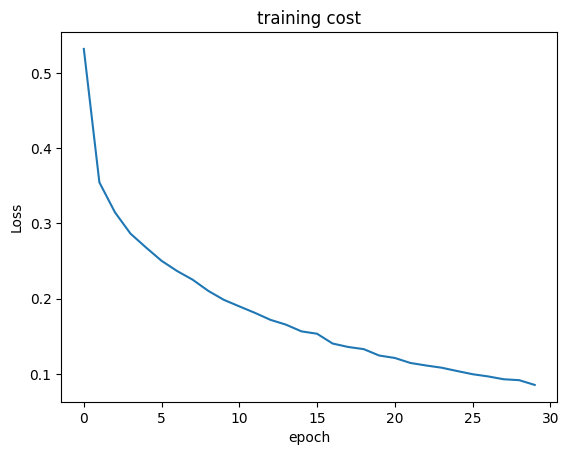

In [ ]:
#costs graph
import matplotlib.pyplot as plt

cost_values = [cost.detach().item() for cost in costs[-30:]]
plt.plot(cost_values)
plt.title('training cost')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

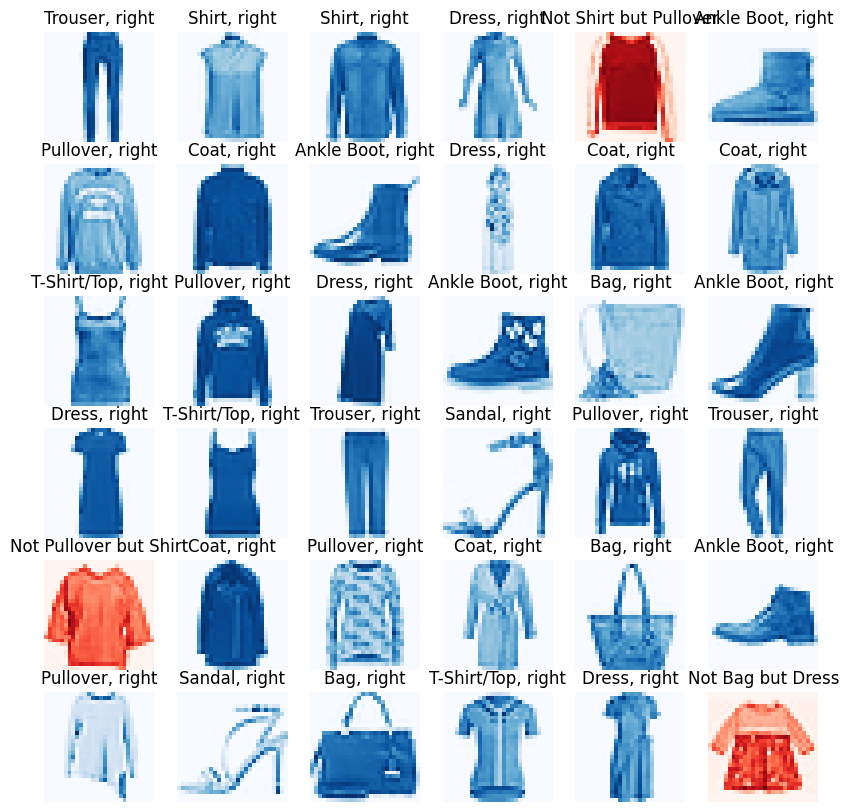

In [ ]:
label_tags = {
    0: 'T-Shirt/Top', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))
 
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    label = label_tags[test_data[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('Not ' + pred + ' but ' +  label)
        cmap = 'Reds'
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 

 ResNet-18

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision.models as models
model = models.resnet18(pretrained=True) # Use pre-trained weights
model.fc = nn.Linear(784, 10) # Modifying the Layer
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.2MB/s]


In [4]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet-18 must have 3 channels in the input image. However, the Fashion MNIST dataset is a black-and-white image, so it has 1 channel count. To resolve this issue, I need to change the number of channels in the input image to 3

In [ ]:
root = './MNIST_Fashion'
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), #change channels count
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
dataset = datasets.FashionMNIST(root=root, transform=transform, download=True)
kfold = KFold(n_splits=k, shuffle=True)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
learning_rate = 0.001
total_accuracy = 0
costs = []
num_epochs = 10

for fold, (train_idxs, val_idxs) in enumerate(kfold.split(dataset)):
    # Split data into training and validation sets
    train_data = torch.utils.data.Subset(dataset, train_idxs)
    val_data = torch.utils.data.Subset(dataset, val_idxs)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    total_batch = len(train_loader)
    
    # Initialize model and optimizer
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(512, 10)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    for epoch in range(num_epochs):
        total_cost = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            #loss_item = loss.item() # get scalar value
            loss.backward()
            optimizer.step()

            total_cost += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        avg_cost = total_cost / total_batch
        print('Fold [{}/{}], Epoch [{}/{}], Validation Accuracy: {:.2f}%, Cost: {:.9f})'
              .format(fold+1, k, epoch+1, num_epochs, accuracy, avg_cost))
        total_accuracy += accuracy
        costs.append(avg_cost) 

# Calculate average accuracy across all folds
avg_accuracy = total_accuracy / k
print('Average Validation Accuracy: {:.2f}%'.format(avg_accuracy))

In [ ]:
# Load test data
test_data = datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Test model
model.eval()
test_accuracy = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_accuracy += (output.argmax(1) == target).sum().item()

test_accuracy /= len(test_data)
print('Test accuracy: {:.4f}'.format(test_accuracy))